# Aula 6 - validação cruzada

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

1. [Cross validation](#pt1)
2. [Ajuste de hiperparâmetros](#pt2)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
WHITE = '\033[39m'
CYAN = '\033[36m'

____

# <span id='pt1' style='font-size:0.8em;color:#1696d2'>1) Cross Validation



O cross validation (CV) é uma das técnicas mais importantes no ferramental de um cientista de dados.

Operacionalmente, o CV implementa diferentes conjuntos de treino e teste (aqui chamados de **validação**), criando efetivamente diferentes modelos treinados e avaliados em diferentes suconjuntos aleatórios (os chamados **folds**) da base de dados original. 

No fim, é possível inspecionar as métricas de interesse em cada fold, bem como ter uma ideia da performance média do modelo, olhando para **a distribuição das métricas de avaliação**.

Note que este procedimento está intimamente relacionado com a avaliação da desejável habilidade de **generalização do modelo**!

A forma mais comum de fazermos CV é através da técnica **k-fold**:

<img src=https://scikit-learn.org/stable/_images/grid_search_cross_validation.png width=500>

No extremo desta abordagem, podemos tomar o número $k$ de folds igual ao número de observações na base ($n$). Neste caso, utiliza-se **uma única** observação para teste, enquanto o resto do dataset é utilizado para treino. Essa abordagem é conhecida como **leave one out (LOO)**:

<img src=https://assets.datacamp.com/production/repositories/3981/datasets/8a6236f142b1ee2e4a70aae2af9507c7c580f302/Screen%20Shot%202019-01-27%20at%209.25.41%20AM.png width=500>

Note que o esforço computacional aumenta conforme $k$ aumenta, sendo máximo quando $k=n$. Por esse motivo, recomenda-se usar o LOO apenas nos casos em que o número de observções na base original é bem pequeno ($\sim 10^2$).

Vamos implementar o procedimento de CV utilizando o sklearn!

No [submódulo model_selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection), temos duas ferramentas muito importantes para o processo de CV:

- [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold): classe que cria os folds. Obs.: para fazer o LOO, basta colocar $k=n$ folds, ou então usar diretamente a classe que implementa o [LOO](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html#sklearn.model_selection.LeaveOneOut);

- [cross_validate](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate): função que recebe os folds e os utiliza para o treinamento e avaliação cruzada de modelos, segundo a métrica definida.

Para ilustrar o CV,  amos utilizar os datasets artificiais que o sklearn proporciona:

_______

Vamos começar com um exemplo de **regressão**

In [2]:
from sklearn.datasets import make_regression

X, y = make_regression(n_samples=500,
                n_features=5,
                n_informative=3,
                noise=25,
                tail_strength=10,
                random_state=42)

features = pd.DataFrame(X, columns=[f'X{i+1}' for i in range(5)])
target = pd.Series(y, name='y')
df = pd.concat([features, target], axis=1)
df

,X1,X2,X3,X4,X5,y
0,-0.109610,0.546284,-0.088363,0.006422,-0.436386,79.870807
1,-1.024388,-0.926930,-0.252568,-0.059525,-3.241267,-115.324859
2,-2.650970,0.106430,1.091507,-0.254977,1.503993,35.552509
3,-0.850520,-0.138456,-0.580523,-1.224298,-0.209023,-145.413703
4,-0.322680,-0.756795,-0.250833,-1.421811,1.501334,-116.148875
...,...,...,...,...,...,...
495,-1.363174,-1.598124,0.189706,0.462173,2.024310,-87.798391
496,0.239247,-1.979300,2.074083,0.747910,-1.072743,-92.452927
497,2.189803,-0.767348,-0.808298,0.872321,0.183342,20.274546
498,0.615367,0.513106,-0.935439,-0.259547,0.738810,43.199300


<AxesSubplot:>

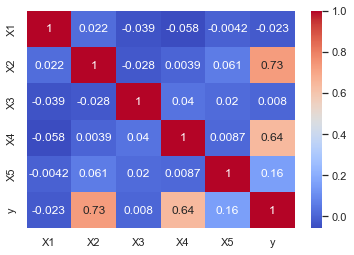

In [3]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')

In [ ]:
sns.pairplot(df)

In [5]:
df.describe()

,X1,X2,X3,X4,X5,y
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.012412,0.047211,0.089335,-0.004983,0.024845,3.420332
std,0.955087,0.969309,0.999397,1.038814,0.949985,110.693405
min,-2.650970,-2.703232,-3.019512,-2.940389,-3.241267,-297.665107
25%,-0.642849,-0.577418,-0.576895,-0.682826,-0.644153,-68.294863
50%,0.033078,0.081273,0.040829,-0.024875,0.008918,4.208483
75%,0.658720,0.668974,0.751524,0.671004,0.635892,76.120529
max,3.078881,3.193108,3.852731,2.558199,3.137749,349.448456


Os dados não têm variação de escala tão grande, então não nos preocuparemos em normaliza-los, caso queiramos utilizar regularização!

**Mas nunca se esqueça que isso é bastante importante quando há grandes diferenças de escala!!**

Agora, implementamos o CV:

In [6]:
from sklearn.model_selection import KFold

In [7]:
kf_5 = KFold(n_splits=5, random_state=42, shuffle=True)

kf_5.split(X,y)

<generator object _BaseKFold.split at 0x129e8f580>

In [8]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import ElasticNet
#from sklearn.preprocessing import MinMaxScaler

In [9]:
en = ElasticNet()

result_cv = cross_validate(estimator=en, X=X, y=y, 
                cv=kf_5, scoring='neg_mean_absolute_error',
                return_train_score=True)

df_result_cv = pd.DataFrame(result_cv).abs()

Vamos olhar pros resultados mais de perto...

In [10]:
df_result_cv

,fit_time,score_time,test_score,train_score
0,0.010574,0.000532,37.242368,34.538921
1,0.000780,0.000394,36.915451,34.920248
2,0.000929,0.000491,33.870163,35.329187
3,0.000722,0.000327,33.954736,35.498673
4,0.000642,0.000312,33.573468,34.382697


In [11]:
df_result_cv[['test_score', 'train_score']].describe()

,test_score,train_score
count,5.000000,5.000000
mean,35.111237,34.933945
std,1.805506,0.483539
min,33.573468,34.382697
25%,33.870163,34.538921
50%,33.954736,34.920248
75%,36.915451,35.329187
max,37.242368,35.498673


Numa unica celula:


In [12]:
from IPython.display import display

In [52]:
def plot_cv(estimator, X, y, n_splits=5, scoring='neg_mean_absolute_error'):
    
    kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)

    result_cv = cross_validate(estimator=estimator, X=X, y=y, 
                    cv=kf, scoring=scoring,
                    return_train_score=True)

    df_result_cv = pd.DataFrame(result_cv).abs()

    display(df_result_cv[['train_score', 'test_score']].describe())

    print('Train distribuition')
    sns.histplot(data=df_result_cv, x='train_score', kde=True)
    plt.show()
    print('Test distribuition')
    sns.histplot(data=df_result_cv, x='test_score', kde=True)
    plt.show()

,test_score,train_score
count,300.000000,300.000000
mean,35.023186,34.912263
std,20.436628,0.040493
min,1.406865,34.762998
25%,20.084035,34.889036
50%,30.976906,34.915924
75%,48.803868,34.937626
max,99.564988,35.073417


Train distribuition


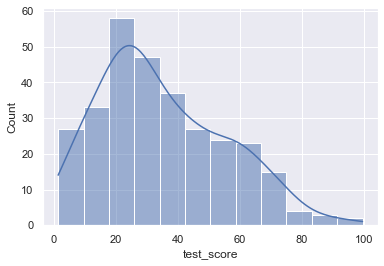

Train distribuition


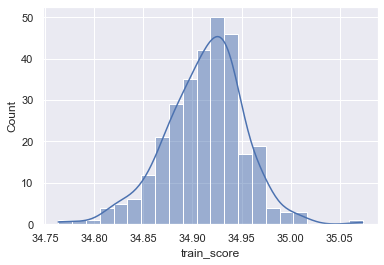

In [14]:
plot_cv(en, X, y, n_splits=300)

Comparando com o train-test split direto

**Na prática, para bases maiores, nós fazemos realmente como está na figura lá em cima**

Isto é:

- primeiro fazemos o train-test split;
- aí, aplicamos CV na base de treino;
- depois testamos na base de teste

Isso é sobretudo importante no segundo "uso" do cv, que é otimização de hiperparametros

______

Caso queira usar mais métricas de uma vez... SEM PROBLEMAS :)

In [24]:
def plot_cv_multiple_metrics(estimator, X, y, n_splits, scoring):
    """
    scoring: str ou tupla de str com os parâmetros de scoring
    """
    
    kf = KFold(n_splits=n_splits, random_state=42, shuffle=True)

    result_cv = cross_validate(estimator=estimator, X=X, y=y, 
                    cv=kf, scoring=scoring,
                    return_train_score=True)

    df_result_cv = pd.DataFrame(result_cv).abs()

    metrics_columns = df_result_cv.columns.tolist()[2:]

    for i in range(0, len(metrics_columns), 2):
        print(f'Metrics distribution: {metrics_columns[i+1].replace("train_","")} (train):')
        sns.histplot(data=df_result_cv, x=metrics_columns[i+1], kde=True)
        plt.show()
        print(f'Metrics distribution: {metrics_columns[i].replace("test_","")} (test):')
        sns.histplot(data=df_result_cv, x=metrics_columns[i], kde=True)
        plt.show()

        print('='*80)


    display(df_result_cv.describe())
    

Metrics distribution: neg_mean_absolute_error (train):


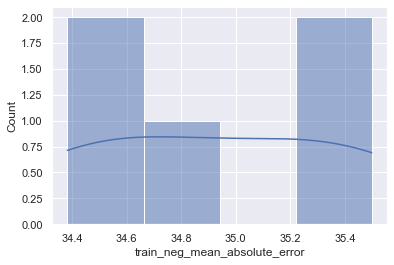

Metrics distribution: neg_mean_absolute_error (test):


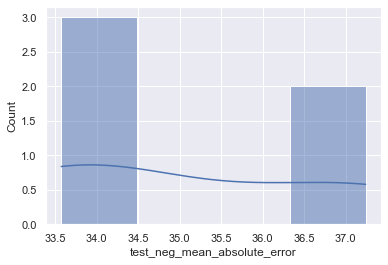

Metrics distribution: neg_root_mean_squared_error (train):


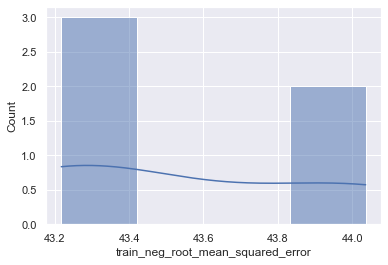

Metrics distribution: neg_root_mean_squared_error (test):


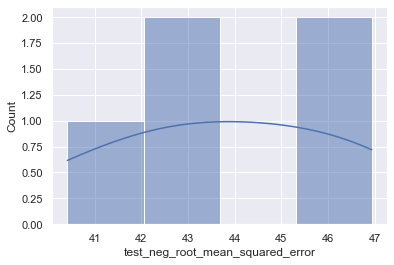

Metrics distribution: r2 (train):


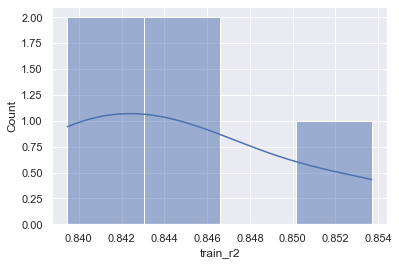

Metrics distribution: r2 (test):


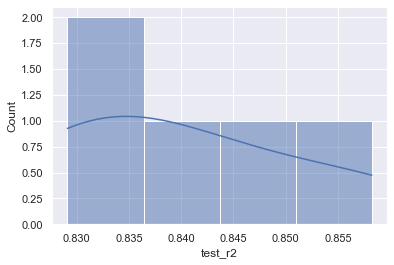

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_root_mean_squared_error,train_neg_root_mean_squared_error,test_r2,train_r2
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.001059,0.001721,35.111237,34.933945,43.838586,43.556593,0.840215,0.844614
std,0.000281,0.001196,1.805506,0.483539,2.563440,0.407638,0.012034,0.005859
min,0.000797,0.000869,33.573468,34.382697,40.419302,43.217668,0.829117,0.839472
25%,0.000881,0.000908,33.870163,34.538921,42.583387,43.276767,0.830471,0.839496
50%,0.000896,0.000914,33.954736,34.920248,43.581829,43.285737,0.837599,0.844345
75%,0.001299,0.002394,36.915451,35.329187,45.674374,43.966468,0.845657,0.846058
max,0.001421,0.003519,37.242368,35.498673,46.934037,44.036324,0.858233,0.853698


In [25]:
plot_cv_multiple_metrics(estimator=en, X=X, y=y, n_splits=5, scoring=('neg_mean_absolute_error', 'neg_root_mean_squared_error', 'r2'))

_____

Vamos agora ver um caso de **classificação**:

In [30]:
from sklearn.datasets import make_classification

X_clf, y_clf = make_classification(n_samples=500,
                            n_features=5,
                            n_informative=3,
                            n_classes=2,
                            random_state=42)

X_clf, y_clf

['X1', 'X2', 'X3', 'X4', 'X5']

In [36]:
clf_columns = [f'X{i+1}' for i in range(X_clf.shape[1])]

df_clf = pd.concat([pd.DataFrame(X_clf, columns=clf_columns),
                    pd.Series(y_clf,name='y')]
                    )

In [37]:
df_clf.head()

,X1,X2,X3,X4,X5,0
0,0.280056,-1.126421,-0.772964,2.060626,-2.357044,NaN
1,-0.326002,0.343967,1.535987,-1.794578,1.293605,NaN
2,-0.802972,-1.112616,-1.088524,0.668720,-1.183952,NaN
3,0.012285,-0.350602,-1.359103,1.234112,-0.909008,NaN
4,0.043145,-1.077267,-0.873334,1.727960,-2.031498,NaN


<AxesSubplot:>

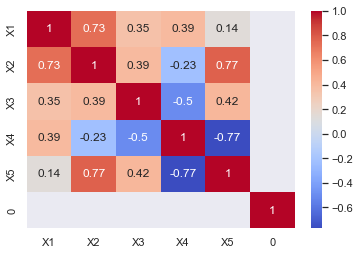

In [40]:
sns.heatmap(df_clf.corr(),cmap='coolwarm', annot=True)

Agora, o CV, bem parecido com o que fizemos acima:

- uma regressão logística com regularização l1 e fator de regularização (C) igual a 1.2;
- 10 folds;
- roc_auc como métrica de avaliação.

In [41]:
from sklearn.linear_model import LogisticRegression

,train_score,test_score
count,30.000000,30.000000
mean,0.942944,0.941086
std,0.001937,0.056607
min,0.939724,0.765625
25%,0.941359,0.905655
50%,0.942892,0.947222
75%,0.944019,0.985795
max,0.947522,1.000000


Train distribuition


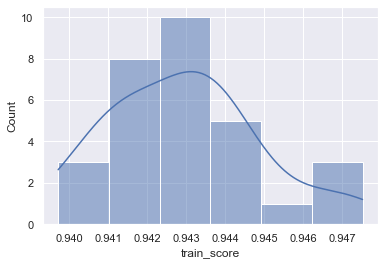

Test distribuition


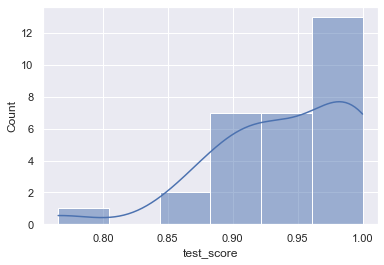

In [53]:
lr = LogisticRegression(penalty='l1', C=1.2, solver='liblinear')

plot_cv(lr, X_clf, y_clf, 30, scoring='roc_auc')

Metrics distribution: roc_auc (train):


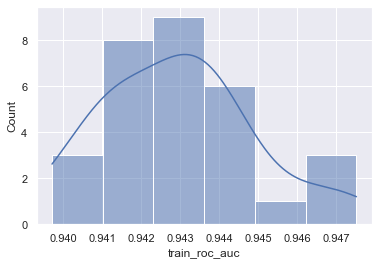

Metrics distribution: roc_auc (test):


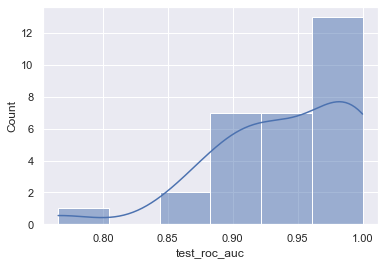

Metrics distribution: f1 (train):


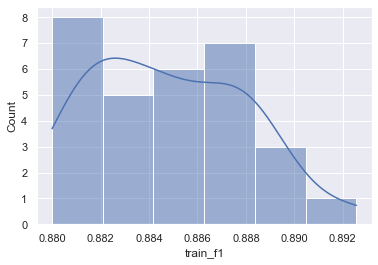

Metrics distribution: f1 (test):


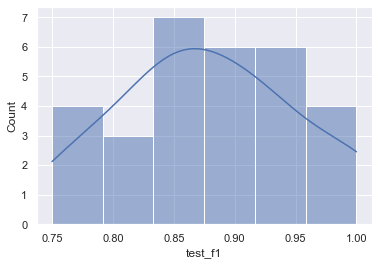

,fit_time,score_time,test_roc_auc,train_roc_auc,test_f1,train_f1
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.005428,0.008598,0.941086,0.942948,0.877976,0.884820
std,0.005602,0.006948,0.056607,0.001935,0.073339,0.003208
min,0.001323,0.002672,0.765625,0.939724,0.750000,0.880000
25%,0.002159,0.004160,0.905655,0.941359,0.835526,0.882019
50%,0.003988,0.005543,0.947222,0.942875,0.875000,0.884774
75%,0.006379,0.010292,0.985795,0.944019,0.930769,0.887500
max,0.029129,0.027629,1.000000,0.947522,1.000000,0.892562


In [54]:
plot_cv_multiple_metrics(lr, X_clf, y_clf, 30, scoring=('roc_auc','f1'))

# <span id='pt2' style='font-size:0.8em;color:#1696d2'> 2) Ajuste de hiperparâmetros

Além de permitir uma avaliação mais robusta de um modelo, o CV pode também ser utilizado para um propósito muito importante: **a escolha de valores adequados de hiperparâmetros** de um modelo -- processo conhecido como **hyperparameter tuning**.

<img src=https://www.okw.com/en/Com-Knobs/COM-KNOBS-class-OKW_GroupInfoImage500x408.jpg width=400>

Na aula que vem vamos estudar uma forma mais estruturada de fazer este procedimento.

Mas, nesta aula, vamos ver formas automáticas e diretas de aplicar CV aos modelos que conhecemos!

Antes de irmos pra prática, uma pergunta importante é: **como/por que utilizar CV para o ajuste de hiperparâmetros?**

Ao testarmos diferentes valores/combinações de hiperparâmetros em diferentes folds, temos uma estimativa mais realista sobre o efeito destas escolhas: se o resultado for bom em todos os folds (ou bom em média), temos um indicativo mais robusto de que de fato aquela é uma boa escolha. Em particular, fica muito mais difícil de cometermos **overfitting** através da escolha de hiperparâmetros que ajustem muito bem uma única base de treino. Faz sentido, né?

Para saber mais sobre estas questões, sugiro [este post](https://towardsdatascience.com/cross-validation-and-hyperparameter-tuning-how-to-optimise-your-machine-learning-model-13f005af9d7d) e [este post](https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/).

No sklearn, temos o procedimento de CV incorporado a algumas classes de hipóteses:

- [Lasso CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html)
- [Ridge CV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html)
- [ElasticNetCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html)
- [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html)

Em todos os casos, é possível especificar uma lista de hiperparâmetros a serem percorridos, e o modelo com melhor hiperparâmetro (ou combinação de hiperparâmetros) é escolhido! 

Vamos pegar as bases acima e aplicar os métodos de CV built-in pra ver se encontramos resultados melhores:

In [55]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, LogisticRegressionCV

In [79]:
l1 = LassoCV(alphas=np.linspace(0.1,1,100), cv=10).fit(X,y)


In [80]:
l1.alpha_

0.8818181818181817

### Agora é sua vez!!

- 1 - Teste diferentes regressores CV com a base house_prices
    - Aumente a complexidade da hipótese permitindo uma regressão polinomial, e deixe o CV decidir uma boa regularização!
    

In [15]:
# house_prices


- 2 - Aplique o logit com CV à base breast_cancer

In [16]:
# breast_cancer
